# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [63]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="white", color_codes=True)
import io

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15802676912572872717
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11796932721533881334
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13261556569505926797
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 9826084189706751892
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:da:00.0, compute capability: 3.5"
]


In [5]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

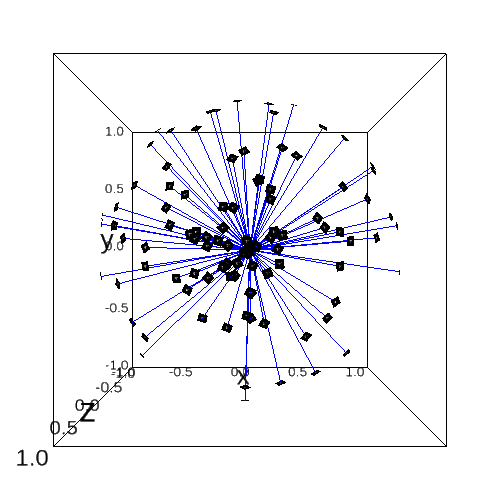

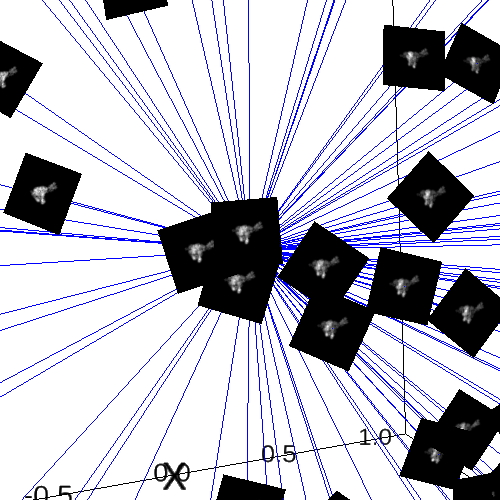

In [10]:
plot_images(angles_true, projections, range(100), img_size_scale=0.05)

In [24]:
ipv.screenshot()

Output()

---

## Prepare for training

In [10]:
from sklearn.model_selection import train_test_split
#from cryoem.distance_estimation import create_pairs

In [11]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

#### Global standardization of projections

In [12]:
from cryoem.distance_estimation import global_standardization

In [13]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [14]:
test_size = 0.33
val_size = 0.25

In [15]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=test_size, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=val_size, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [16]:
print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6312656
TEST :               0.33 =>  1650 imgs => max pairs:    2722500
VAL  : 0.67 x 0.25 = 0.17 =>   837 imgs => max pairs:     701406


In [17]:
np.save("data/5j0n/test_idx", test_idx)

In [15]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [16]:
X = np.stack((X,)*3, axis=-1)

In [17]:
X.shape

(5000, 116, 116, 3)

# 1. Distance Estimation

### Train the model

In [18]:
from time import time

In [38]:
dQ_values = np.load("data/5j0n/dQ_values.npy")
dQ_values = np.around(dQ_values, 1)

cnt = Counter(dQ_values)
keys = np.array(list(cnt.keys()))
#values = sum(cnt.values())/np.array(list(cnt.values()))
values = np.array(list(cnt.values()))
#values = np.abs((values - np.mean(values)))/np.std(values)
#values = 0.037 + values
print(np.min(values))

total = sum(cnt.values(), 0.0)
for key in cnt:
    cnt[key] /= total

#coeffs4rprobability = np.polyfit(keys, values, deg=2)
#convert2rprobability = np.poly1d(coeffs4rprobability)

1


In [53]:
dQ_values = np.load("data/5j0n/dQ_values.npy")
dQ_values = np.around(dQ_values, 1)

cnt = np.histogram(dQ_values, bins=31, range=(0.0, np.pi), density=True)
#keys = np.array(list(cnt.keys()))
#values = sum(cnt.values())/np.array(list(cnt.values()))
#values = np.array(list(cnt.values()))
#values = np.abs((values - np.mean(values)))/np.std(values)
#values = 0.037 + values
print(np.min(values))

#total = sum(cnt.values(), 0.0)
#for key in cnt:
#    cnt[key] /= total

#coeffs4rprobability = np.polyfit(keys, values, deg=2)
#convert2rprobability = np.poly1d(coeffs4rprobability)

1


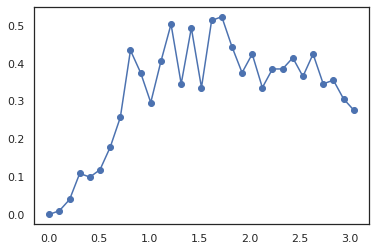

In [56]:
plt.plot(cnt[1][:-1], cnt[0], marker='o')

In [22]:
idx1 = list(np.random.choice(test_idx, size=100000))
idx2 = list(np.random.choice(test_idx, size=100000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dQ_values = d_q(q1_true, q2_true).numpy()

np.save("data/5j0n/dQ_values_100K.npy", dQ_values)

In [22]:
dQ_values = np.load("data/5j0n/dQ_values_100K.npy")

In [23]:
cnt = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
probabilities = cnt[0]
weights = 1/probabilities
weights_norm = weights/sum(weights)

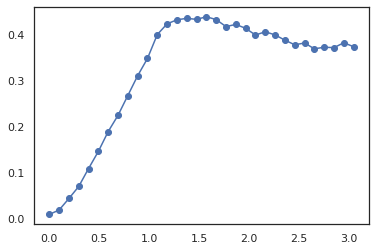

In [24]:
plt.plot(cnt[1][:-1], probabilities, marker='o')

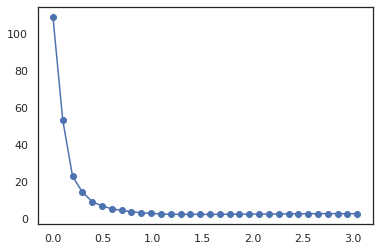

In [44]:
plt.plot(cnt[1][:-1], weights, marker='o')

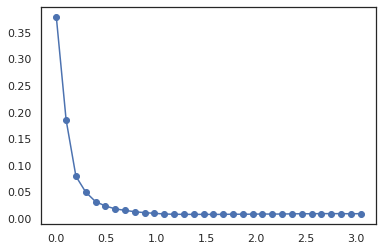

In [45]:
plt.plot(cnt[1][:-1], weights_norm, marker='o')

In [25]:
cnt = np.histogram(dQ_values, bins=32, range=(0.0, np.pi))

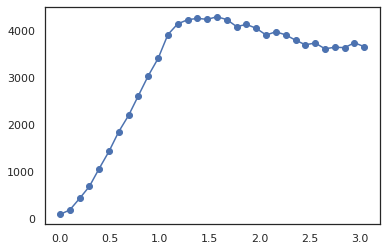

In [27]:
plt.plot(cnt[1][:-1], cnt[0], marker='o')

In [28]:
cnt[0]

array([  90,  184,  429,  686, 1067, 1433, 1855, 2200, 2622, 3043, 3411,
       3920, 4148, 4234, 4265, 4243, 4299, 4238, 4089, 4136, 4052, 3910,
       3979, 3912, 3800, 3702, 3740, 3616, 3650, 3641, 3746, 3660])

In [29]:
# # NO UNIFORM, RANDOM FULL PROBABILITY WEIGHTS
# from tensorflow.keras.utils import Sequence

# num_dec = 1
# num_bins = 32

# dQ_values = np.load("data/5j0n/dQ_values_100K.npy")
# distribution = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
# probabilities = distribution[0]
# weights = 1/probabilities
# weights_norm = weights/sum(weights)

# class DataGenerator(Sequence):
    
#     def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
#         self.X = X  
#         self.y = y  
#         self.limit_num_pairs = limit_num_pairs
#         # all the possible combinations of 2 image id pairs
#         self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
#         # Don't use all possible combination of pairs, limit them here
#         if self.limit_num_pairs and limit_style=="random":
#             limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
#             self.pair_ids = self.pair_ids[limited_pair_indices]
      
#         self.batch_size = batch_size    
#         self.shuffle = shuffle 
#         self._on_epoch_start()
    
#     def __len__(self):
#         # Denotes the number of batches per epoch
#         if len(self.pair_ids)%self.batch_size == 0:
#             return len(self.pair_ids) // self.batch_size
#         else:
#             return len(self.pair_ids) // self.batch_size + 1
        
#     def __getitem__(self, index):
#         # Generate one batch of data
#         indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
#         # Find list of ids
#         list_ids_batch = np.take(self.pair_ids, indices, axis=0)

#         # Generate data
#         idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
#         pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
#         labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)
#         weights = np.array(self._get_weights(labels))
#         labels_and_weights = np.stack((labels, weights), axis=1)
        
#         # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
#         return [pairs[:, 0], pairs[:, 1]], labels_and_weights
        
#     def _get_weights(self, labels):
#         l = labels.numpy()
#         return np.array(list(map(lambda x: weights_norm[np.where(x >= distribution[1])[0][-1]], l)))
        
#     def _on_epoch_start(self):
#         # Updates indices after each epoch
#         self.indices = np.arange(len(self.pair_ids))
#         if self.shuffle:
#             np.random.shuffle(self.indices)     

In [19]:
# CALCULATE FULL 
from tensorflow.keras.utils import Sequence

num_dec = 1
num_bins = 32

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
      
  
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
        
    def _generate_uniform(self):
        if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bins = {}
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                bins[np.around(i, num_dec)] = []


            for idx1, idx2 in self.pair_ids:
                label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
                bins[np.around(label, num_dec)].append([idx1, idx2])

            #for b in bins:
            #    print(b, len(bins[b]))

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                b = np.around(i, num_dec)
                #print(bins[b])
                bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

            #print(bins)
            l = np.array(list(itertools.chain(*list(bins.values()))))
            np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", 31*min_bin_size)
            #print(l)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)
        #weights = np.array(self._get_weights(labels))
        #labels_and_weights = np.stack((labels, weights), axis=1)
        
        # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
        return [pairs[:, 0], pairs[:, 1]], labels   #labels_and_weights
        
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)     

In [20]:
# # CALCULATE PER BATCH
# from tensorflow.keras.utils import Sequence

# num_dec = 1
# num_bins = 32

# class DataGenerator(Sequence):
    
#     def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=False):
#         self.X = X  
#         self.y = y  
#         self.limit_num_pairs = limit_num_pairs
#         # all the possible combinations of 2 image id pairs
#         self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
#         self.limit_style = limit_style
        
#         # Don't use all possible combination of pairs, limit them here
#         if self.limit_num_pairs:
#             limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
#             self.pair_ids = self.pair_ids[limited_pair_indices]
      
#         self.batch_size = batch_size    
#         self.shuffle = shuffle 
#         self._on_epoch_start()
#         self.index = 0
        
#     def _all_bins_filled(self, bins):
#         for v in bins.values():
#             if len(v) <= self.batch_size//num_bins:
#                 return False
#         return True
    
#     def _generate_uniform(self):
#         bins = {}
#         for i in np.linspace(0.0, 3.1, num=num_bins): # so we have 31 bin
#             bins[np.around(i, num_dec)] = []

#         for i, (idx1, idx2) in enumerate(self.pair_ids[self.index:]):
#             label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
#             if len(bins[np.around(label, num_dec)]) <= self.batch_size//num_bins:
#                 bins[np.around(label, num_dec)].append([idx1, idx2])
                
#             if self._all_bins_filled(bins):
#                 self.index += i
#                 break
#         else:
#             # if it didn't fill the bins, reset the index
#             self.index = 0
        
#         return np.array(list(itertools.chain(*list(bins.values()))))
    
#     def __len__(self):
#         # Denotes the number of batches per epoch
#         if len(self.pair_ids)%self.batch_size == 0:
#             return len(self.pair_ids) // self.batch_size
#         else:
#             return len(self.pair_ids) // self.batch_size + 1
        
#     def __getitem__(self, index):
#         if self.limit_style=="random":
#             # Generate one batch of data
#             indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

#             # Find list of ids
#             list_ids_batch = np.take(self.pair_ids, indices, axis=0)
#         elif self.limit_style=="uniform":
#             list_ids_batch = self._generate_uniform()

#         # Generate data
#         idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
#         pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
#         labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)
#         #weights = np.array(self._get_weights(labels))
#         #labels_and_weights = np.stack((labels, weights), axis=1)
        
#         # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
#         return [pairs[:, 0], pairs[:, 1]], labels   #labels_and_weights
        
#     # def _get_weights(self, labels):
#     #      return convert2rprobability(labels)
        
#     def _on_epoch_start(self):
#         # Updates indices after each epoch
#         self.indices = np.arange(len(self.pair_ids))
#         if self.shuffle:
#             np.random.shuffle(self.indices)     

In [44]:
# idx1 = list(np.random.choice(test_idx, size=1000))
# idx2 = list(np.random.choice(test_idx, size=1000))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# dQ_values = d_q(q1_true, q2_true).numpy()

In [45]:
# plt.hist(dQ_values, bins=100);

In [46]:
# plt.plot(np.arange(0,np.pi,0.01), convert2rprobability(np.arange(0,np.pi,0.01)), marker="*", markersize=2, lw=0, c="r");

In [30]:
# np.min(convert2rprobability(np.arange(0,np.pi,0.01)))

In [29]:
# len(train_idx)

In [35]:
start_time = time()
g = DataGenerator(X, y, train_idx, limit_num_pairs=5000, limit_style="uniform")
print(time()-start_time)
dQ_values_dg = []
for i in g:
    #print(i[0][0].shape, i[1].shape)
    dQ_values_dg.extend(list(i[1].numpy()))
    #print(np.min(i[0][0]), np.max(i[0][0]))
print(time() - start_time)

Data created in 4.492850065231323 sec
4.4935736656188965
4.539700984954834


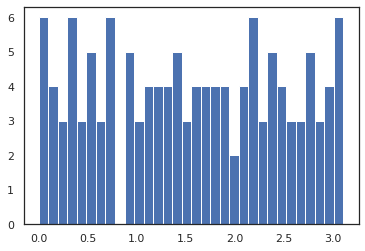

In [36]:
#dQ_values_dg= np.around(dQ_values_dg, 1)
plt.hist(dQ_values_dg, bins=32);

In [50]:
s1 = np.histogram(dQ_values_dg, bins=31, density=True)
s1

(array([0.4679682, 0.3119788, 0.2339841, 0.4679682, 0.2339841, 0.3899735,
        0.2339841, 0.4679682, 0.2339841, 0.3119788, 0.1559894, 0.4679682,
        0.2339841, 0.3119788, 0.3119788, 0.1559894, 0.4679682, 0.1559894,
        0.4679682, 0.3119788, 0.2339841, 0.4679682, 0.3119788, 0.3119788,
        0.3119788, 0.2339841, 0.2339841, 0.4679682, 0.2339841, 0.3119788,
        0.4679682]),
 array([7.88495335e-08, 1.00167140e-01, 2.00334202e-01, 3.00501264e-01,
        4.00668325e-01, 5.00835387e-01, 6.01002449e-01, 7.01169510e-01,
        8.01336572e-01, 9.01503634e-01, 1.00167070e+00, 1.10183776e+00,
        1.20200482e+00, 1.30217188e+00, 1.40233894e+00, 1.50250600e+00,
        1.60267307e+00, 1.70284013e+00, 1.80300719e+00, 1.90317425e+00,
        2.00334131e+00, 2.10350837e+00, 2.20367543e+00, 2.30384250e+00,
        2.40400956e+00, 2.50417662e+00, 2.60434368e+00, 2.70451074e+00,
        2.80467780e+00, 2.90484487e+00, 3.00501193e+00, 3.10517899e+00]))

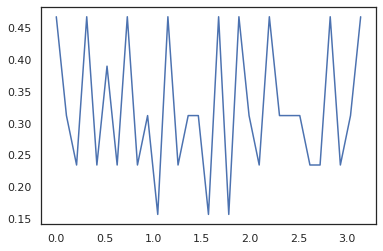

In [51]:
plt.plot(np.linspace(0, 3.14, num=31), s1[0])

In [39]:
# plt.plot(np.linspace(0, 3.1, 32),np.histogram(dQ_values_dg, bins=32)[0], marker='o')
# plt.hist(dQ_values_dg, bins=32);

In [40]:
import tensorflow_probability as tfp

In [41]:
s = tfp.stats.histogram(dQ_values_dg, np.arange(0.0, 3.14, 0.1))
s /= sum(s.numpy())

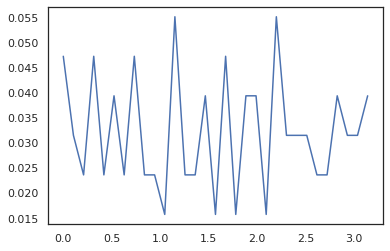

In [42]:
plt.plot(np.linspace(0, 3.14, num=31), s.numpy())

In [45]:
s3 = get_probabilities(np.array(dQ_values_dg).astype(np.float32))
s3

<tf.Tensor: shape=(31,), dtype=float32, numpy=
array([0.04724409, 0.03149606, 0.02362205, 0.04724409, 0.02362205,
       0.03937008, 0.02362205, 0.04724409, 0.02362205, 0.02362205,
       0.01574803, 0.05511811, 0.02362205, 0.02362205, 0.03937008,
       0.01574803, 0.04724409, 0.01574803, 0.03937008, 0.03937008,
       0.01574803, 0.05511811, 0.03149606, 0.03149606, 0.03149606,
       0.02362205, 0.02362205, 0.03937008, 0.03149606, 0.03149606,
       0.03937008], dtype=float32)>

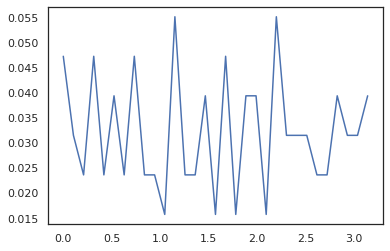

In [46]:
plt.plot(np.linspace(0, 3.14, num=31), s3.numpy())

In [20]:
import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE

_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None
        
def get_probabilities(x):
    #probs = np.histogram(x, bins=32, range=(0.0, np.pi), density=True)
    #return probs[0]
    s = tfp.stats.histogram(x, tf.range(0.0, 3.14, 0.1))
    s = tf.math.divide(s, K.sum(s))
    return s

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    y_true_probs = get_probabilities(y_true)
    #print(y_pred)
    y_pred_prob = get_probabilities(y_pred)
    #y_true, weights = y_true[:, 0], y_true[:, 1]
    return MAE(y_true, y_pred) + K.abs(KLD(y_true_probs, y_pred_prob))#K.mean(weights*K.square(y_true-y_pred)) #weights*K.abs(MAE(y_true, y_pred)) #+ K.abs(KLD(y_true, y_pred))


def mse(y_true, y_pred):
    y_true_probs = get_probabilities(y_true)
    #print(y_pred)
    y_pred_prob = get_probabilities(y_pred)
    
    #y_true, weights = y_true[:, 0], y_true[:, 1]
    return MSE(y_true, y_pred) + K.abs(KLD(y_true_probs, y_pred_prob)) #K.mean(weights*K.abs(y_true-y_pred)) #weights*K.abs(MSE(y_true, y_pred)) #+ K.abs(KLD(y_true, y_pred))

def mlp(vects):
    x, y = vects
    Concatenate(axis=-1)
    
def mlp_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def create_siamese_network(input_shape):
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    input_x = Input(shape=input_shape)
    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_x, input_shape=input_shape)
    x = base_model.layers[-1].output
    
    #for i, layer in enumerate(base_model.layers):
    #    print(i, layer.name, layer.output_shape)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)
    
#     # let's add a fully-connected layer
#     x = Dense(1024, activation='relu')(x)

#     for layer in base_model.layers:
#         layer.trainable = False
    
    return Model(input_x, x)

def create_distance_network(input_shape):
    # ref: https://github.com/guanjianyu/DisNet/blob/master/Train_DisNet.py
    # ref: https://project.inria.fr/ppniv18/files/2018/10/paper22.pdf
    input_x = Input(shape=input_shape)
    
    #x = Flatten()(input_x)

    x = Dense(2000, activation="relu")(input_x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1, activation="relu")(x)
    
    return Model(input_x, x)



def train_siamese(X, y, train_idx, val_idx, epochs_top, epochs_full, batch_size, learning_rate, training_steps=None, validation_steps=None, plot=True, gpus=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        dP_values = d_p(p1, p2).T[0]
        dQ_values = d_q(q1_true, q2_true).numpy()

        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            #plt.clf()
            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot
    
    #print("TensorFlow version: {}".format(tf.__version__))
    #print("Eager execution: {}".format(tf.executing_eagerly()))
    #tf.config.experimental_run_functions_eagerly(True)
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, limit_style="uniform", shuffle=True)
        validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, limit_style="uniform", shuffle=True)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
        #siamese_output = Concatenate()([processed_a, processed_b])
        #siamese_output = tf.keras.backend.stack([processed_a, processed_b])
        #print(f"Output shape of the SiameseNN {siamese_output.shape}")
        #distance_network = create_distance_network(siamese_output.shape)
        #distance = distance_network(siamese_output)
        
        m = Model([input_a, input_b], distance)  # was m

        global model
        # train
        model = multi_gpu_model(m, gpus=gpus)
        model.summary()
        plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)
        
        # Setup callbacks
        # Create a callback that saves the model's weights
        #CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
        #pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
        #backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
        #                                  save_weights_only=True,
        #                                  verbose=1)
        # Create a callback that will show tensorboard data
        LOGS_PATH = os.path.join("logs", strftime('%Y%m%d_%H%M%S'))
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
        
        file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
        plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))

        # Create a callback that will decrease LR if it gets plateau in val_loss
        #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)
        
        
        history1 = model.fit(training_generator, 
                            epochs=epochs_top,
                            validation_data=validation_generator, 
                            callbacks=[plot_callback, logs_callback])
        
        
        if plot:
            # Get training and test loss histories
            training_loss = history1.history['loss']
            val_loss = history1.history['val_loss']
            mses = history1.history['mse']
            val_mses = history1.history['val_mse']

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();


#         # at this point, the top layers are well trained and we can start fine-tuning
#         # convolutional layers from inception V3. We will freeze the bottom N layers
#         # and train the remaining top layers.

#         # we chose to train the top 2 inception blocks, i.e. we will freeze
#         # the first 249 layers and unfreeze the rest:
#         for layer in model.layers[:249]:
#             layer.trainable = False
#         for layer in model.layers[249:]:
#             layer.trainable = True
            
#         # we train our model again (this time fine-tuning the top 2 inception blocks
#         # alongside the top Dense layers
#         optimizer2 = Adam(lr=1e-3)
#         model.compile(optimizer=optimizer2, loss=mae, metrics=['mse'])
#         history2 = model.fit(training_generator,
#                             epochs=epochs_full,
#                             validation_data=validation_generator, 
#                             callbacks=[logs_callback, reduce_on_plateau_callback])
            
        model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
        model.save(model_filename) 
        print(f"Model saved to: {model_filename}")
        
#         if plot:
#             # Get training and test loss histories
#             training_loss = history2.history['loss']
#             val_loss = history2.history['val_loss']
#             mses = history2.history['mse']
#             val_mses = history2.history['val_mse']

#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

#             # Create count of the number of epochs
#             epoch_count = range(1, len(training_loss) + 1)

#             # Visualize loss history
#             ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
#             ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
#             ax1.legend()
#             ax1.set_xlabel('Epoch')
#             ax1.set_ylabel('Loss')

#             ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
#             ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
#             ax2.legend()
#             ax2.set_xlabel('Epoch')
#             ax2.set_ylabel('Loss')
#             plt.show();

        return model, history1 #, history2

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [21]:
train_percent = 0.1
val_percent = 0.1
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(631014, 70224)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Data created in 4.466503858566284 sec
Data created in 0.4941675662994385 sec
Input images shape (116, 116, 3)


/home/jbanjac/anaconda3/envs/protein_reconstruction/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Epoch 27/200
37/37 [==============================] - 31s 836ms/step - loss: 1.2019 - mse: 1.0553 - val_loss: 1.8883 - val_mse: 1.5591
Epoch 28/200
37/37 [==============================] - 30s 824ms/step - loss: 1.1388 - mse: 1.0142 - val_loss: 1.3702 - val_mse: 1.0544
Epoch 29/200
37/37 [==============================] - 31s 844ms/step - loss: 1.1679 - mse: 1.0419 - val_loss: 1.3806 - val_mse: 1.1054
Epoch 30/200
37/37 [==============================] - 31s 829ms/step - loss: 1.1799 - mse: 1.0463 - val_loss: 1.3714 - val_mse: 1.1705
Epoch 31/200
37/37 [==============================] - 31s 832ms/step - loss: 1.1972 - mse: 1.0626 - val_loss: 0.9974 - val_mse: 0.7098
Epoch 32/200
37/37 [==============================] - 31s 829ms/step - loss: 1.1468 - mse: 1.0125 - val_loss: 1.6252 - val_mse: 1.4429
Epoch 33/200
37/37 [==============================] - 31s 839ms/step - loss: 1.1306 - mse: 0.9839 - val_loss: 1.4315 - val_mse: 1.2266
Epoch 34/200
37/37 [==============================] - 3

Epoch 88/200
37/37 [==============================] - 31s 842ms/step - loss: 0.6765 - mse: 0.5758 - val_loss: 1.6599 - val_mse: 1.4361
Epoch 89/200
37/37 [==============================] - 31s 841ms/step - loss: 0.6639 - mse: 0.5705 - val_loss: 1.6295 - val_mse: 1.4164
Epoch 90/200
37/37 [==============================] - 30s 820ms/step - loss: 0.6372 - mse: 0.5447 - val_loss: 1.5301 - val_mse: 1.3420
Epoch 91/200
37/37 [==============================] - 31s 835ms/step - loss: 0.6679 - mse: 0.5664 - val_loss: 1.4831 - val_mse: 1.2074
Epoch 92/200
37/37 [==============================] - 31s 844ms/step - loss: 0.6235 - mse: 0.5302 - val_loss: 1.4826 - val_mse: 1.2698
Epoch 93/200
37/37 [==============================] - 31s 846ms/step - loss: 0.6244 - mse: 0.5270 - val_loss: 1.7739 - val_mse: 1.5730
Epoch 94/200
37/37 [==============================] - 30s 820ms/step - loss: 0.6970 - mse: 0.6030 - val_loss: 1.7288 - val_mse: 1.5172
Epoch 95/200
37/37 [==============================] - 3

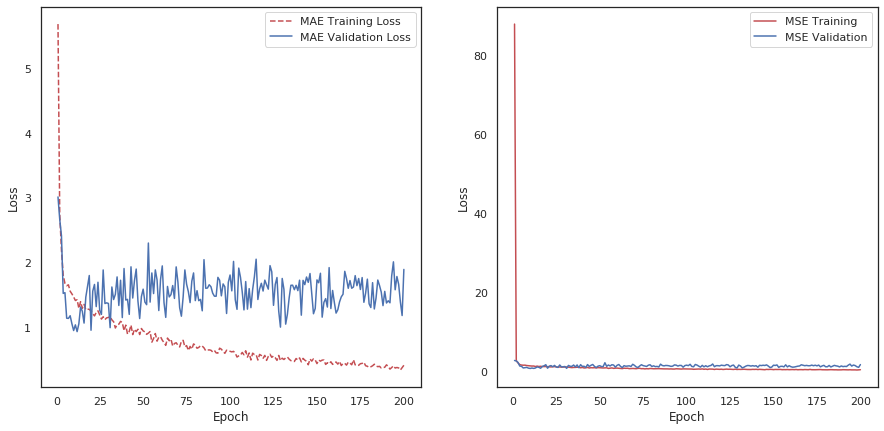

Model saved to: training/20200601_022855.h5


In [23]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=200,  #500
                               epochs_full=None,
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=2)

In [21]:
#from tensorflow.keras.models import load_model
# import tensorflow_hub as hub

# def build_model(loaded, input_shape):
#     input_x = Input(shape=input_shape)
#     # Wrap what's loaded to a KerasLayer
#     keras_layer = hub.KerasLayer(loaded, trainable=True)(input_x)
#     model = tf.keras.Model(x, keras_layer)
#     return model
    
def continue_training(model_filename, X, y, train_idx, val_idx, epochs_top, epochs_full, batch_size, learning_rate, training_steps=None, validation_steps=None, plot=True, gpus=None):
    #tf.enable_eager_execution()
    
    #mirrored_strategy = tf.distribute.MirroredStrategy()
    
    #with mirrored_strategy.scope():
        
    #input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
    #print(f"Input images shape {input_shape}")

    #loaded = tf.saved_model.load('training/20200521_084626.h5')
    #m = build_model(loaded, input_shape)
    #Load partly trained model
    #m = tf.keras.models.load_model('training/20200521_084626.h5')
    m = tf.keras.models.load_model(model_filename)

    # train
    model = multi_gpu_model(m, gpus=gpus)
    model.summary()
    #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

    training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps)
    validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps)

    # Setup callbacks
    # Create a callback that saves the model's weights
    #CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
    #pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
    #backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
    #                                  save_weights_only=True,
    #                                  verbose=1)
    # Create a callback that will show tensorboard data
    LOGS_PATH = os.path.join("logs", strftime('%Y%m%d_%H%M%S'))
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)

    # Create a callback that will decrease LR if it gets plateau in val_loss
    reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)


    # training only top layers
    optimizer1 = RMSprop(learning_rate=learning_rate)
    model.compile(loss=mae, optimizer=optimizer1, metrics=['mse'])
    #Continue training
    history = model.fit(training_generator, 
                        epochs=epochs_top,
                        validation_data=validation_generator, 
                        callbacks=[logs_callback, reduce_on_plateau_callback])

    return model, history

In [ ]:
model, history2 = continue_training(model_filename='training/20200521_084626.h5',X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=20,  #500
                               epochs_full=None,
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 116, 116, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 116, 116, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

---

In [35]:
training_loss = history1.history['loss']
val_loss = history1.history['val_loss']
mses = history1.history['mse']
val_mses = history1.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history_uniform", training_loss, val_loss, mses, val_mses)

In [35]:
# training_loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']
# mses2 = history2.history['mse']
# val_mses2 = history2.history['val_mse']

# np.savez("data/5j0n/5j0n_DE_history_stage2", training_loss2, val_loss2, mses2, val_mses2)

In [36]:
# training_loss += training_loss2
# val_loss += val_loss2
# mses += mses2
# val_mses += val_mses

In [36]:
data = np.load("data/5j0n/5j0n_DE_history_uniform.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

In [37]:
limit = 199

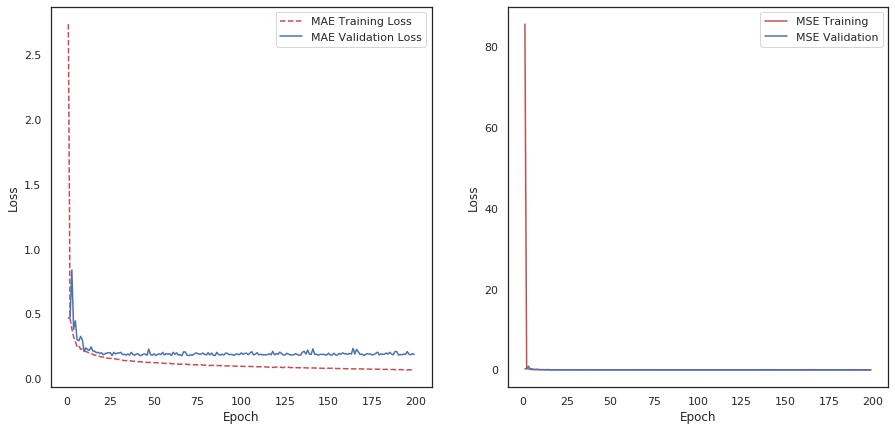

In [38]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count[:limit], training_loss[:limit], 'r--', label='MAE Training Loss')
ax1.plot(epoch_count[:limit], val_loss[:limit], 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count[:limit], mses[:limit], 'r-', label='MSE Training')
ax2.plot(epoch_count[:limit], val_mses[:limit], 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [39]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(0.06818553585162278, 0.18914438287417093, 0.009661273, 0.06259676)

In [40]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(0.00010196198448029379, 0.00013733559804016046, 4.607726e-06, 9.539637e-06)

In [41]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(20.34968684555079, 20.15308006286621, 17.759182, 17.617468)

In [37]:
# training_loss[50], val_loss[50], mses[50], val_mses[50]

### (Or) Read model checkpoint

In [40]:
# stop here, change file

In [20]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
#model_filename = "training/20200422_114231.h5"
#model_filename = "training/20200430_022437.h5" full 2
#model_filename = "training/20200430_212106.h5" full 3
#model_filename = "training/20200504_232357.h5"
#model_filename = "training/20200505_191430.h5"  PGN
#model_filename = "training/20200507_070831.h5" 
#model_filename = "training/20200508_020958.h5" # fixed MLP + MobileNet | NOT REALLY was ran with Eucl
# small ds

#model_filename = "training/20200508_020958.h5"
#model_filename = "training/20200526_054602.h5"
#model_filename = "training/20200527_091717.h5"
#model_filename = "training/20200530_103447.h5"
#model_filename = "training/20200601_022855.h5" # KLD
#model_filename = "training/20200530_103447.h5"  # no KLD
model_filename = "training/20200531_224202.h5"
#model_filename = "training/20200601_022855.h5" # KLD

In [21]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 116, 116, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 116, 116, 3)  0           input_8[0][0]                    
____________________________________________________________________________________________

### Some model results

In [40]:
# from cryoem.distance_estimation import plot_results

In [41]:
# y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
# y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [42]:
# plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
# plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

In [43]:
# plot_train_results(1)

In [44]:
# plot_validation_results(0)

---

## dP/dQ plot

In [22]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [23]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [24]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

AttributeError: 'NoneType' object has no attribute 'predict'

In [46]:
np.savez("data/5j0n/5j0n_DE_dPdQ_plot_full_add_loss", dP_values, dQ_values)

In [47]:
data = np.load("data/5j0n/5j0n_DE_dPdQ_plot_full_add_loss.npz")
dP_values, dQ_values = data['arr_0'], data['arr_1']

<Figure size 432x288 with 0 Axes>

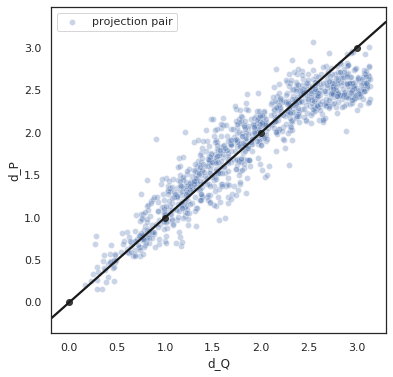

<Figure size 432x288 with 0 Axes>

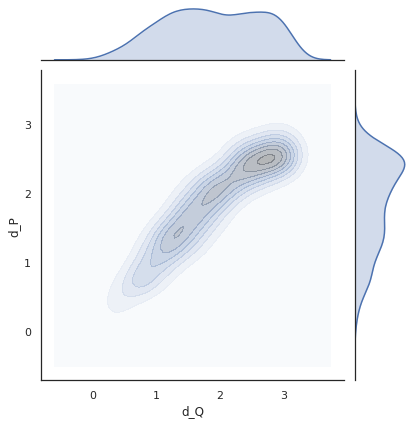

Variance = 0.2690672323834601
Min. angle recovery loss possible = 0.07232477836695243


In [25]:
plot_dP_dQ(dP_values, dQ_values)

In [26]:
MAE(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float32, numpy=0.21109173>

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [ ]:
from cryoem.angle_recovery import train_angle_recovery

In [29]:
# X = tf.cast(X, dtype=tf.float64)
# X = X.numpy()

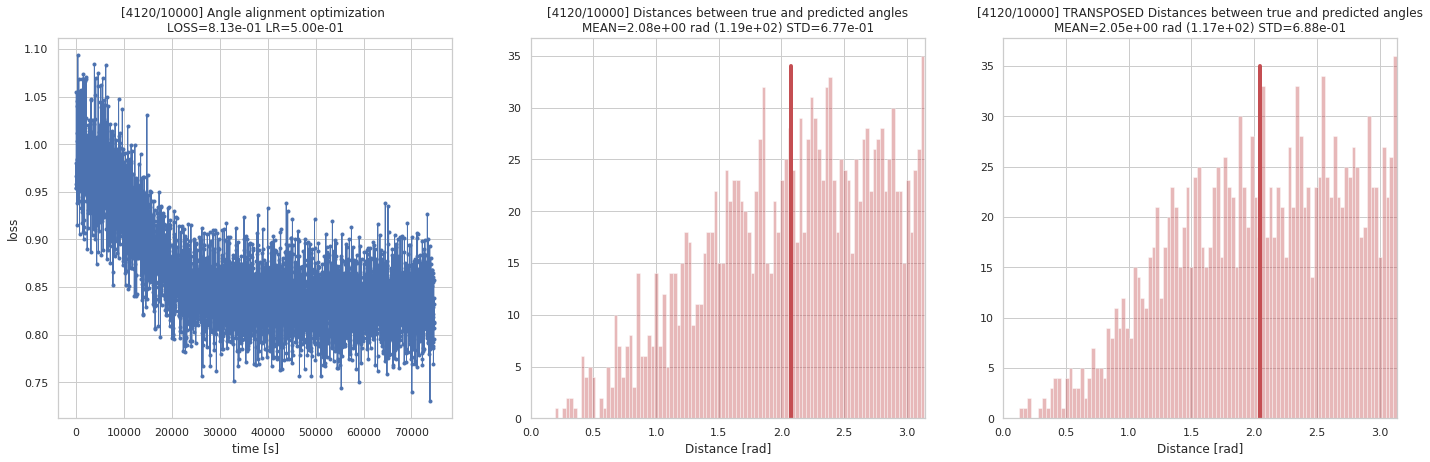

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=10000, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.5,
                                                   angles_true=y[test_idx],
                                                   optimization=True,
                                                 file_name="data/5j0n/angle_recovery_polynomial")

In [25]:
data = np.load("data/5j0n/angle_recovery_polynomial.npz")
q_predicted, losses, q_all = data['arr_0'], data['arr_1'], data['arr_2']

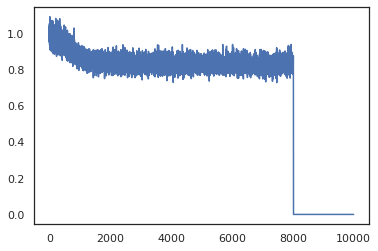

In [29]:
plt.plot(losses)

In [31]:
from cryoem.conversions import quaternion2euler
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)
np.save("data/5j0n/predicted_angles_siamese_kld.npy", angles_predicted)

##### Plots

In [61]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

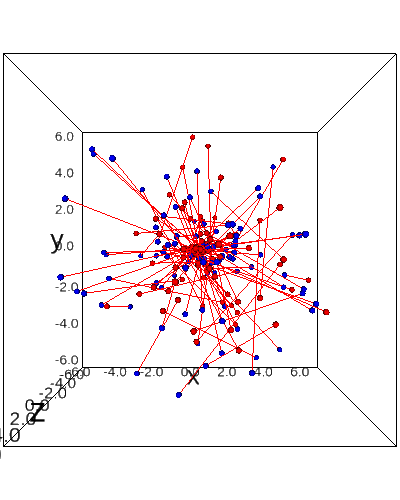

In [65]:
plot_iterations_polar_plot(q_all, angles_true[test_idx], interval=100, selected=range(102));

In [66]:
ipv.screenshot()

Output()

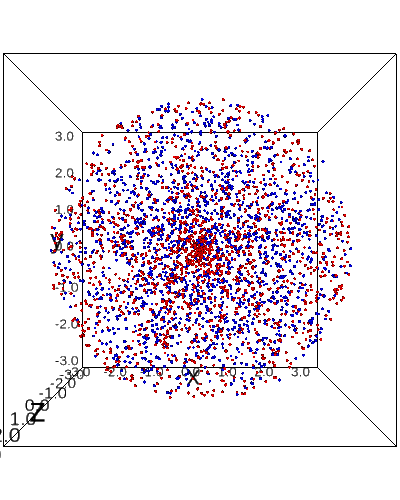

In [67]:
plot_iterations_rotvec(q_all, angles_true[test_idx], interval=100);

In [68]:
ipv.screenshot()

Output()

In [69]:
from cryoem.plots import plot_images

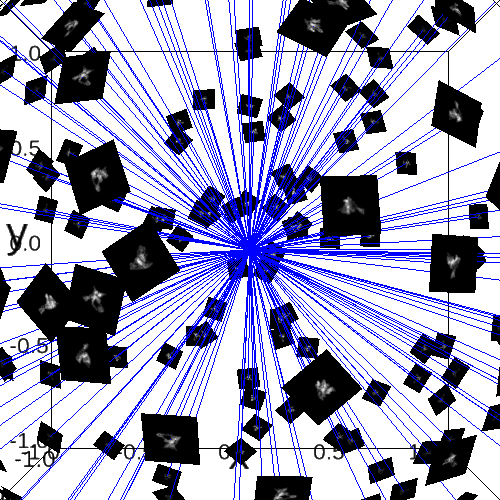

In [70]:
plot_images(angles_predicted, projections, indices=range(200), img_size_scale=0.1)

In [71]:
ipv.screenshot()

Output()

---

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

---

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [45]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [54]:

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R
from cryoem.conversions import euler2quaternion, d_q


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, optimizer, learning_rate, learning_rate_power, angles_true, angles_predicted):
    
    collect_data = []

    optimizer = optimizer(learning_rate=learning_rate, learning_rate_power=learning_rate_power)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(m, a_R, q_predicted)

            collect_data.append(qu.numpy())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(.1)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    print("---")
    return m, a_R, losses, np.array(collect_data)

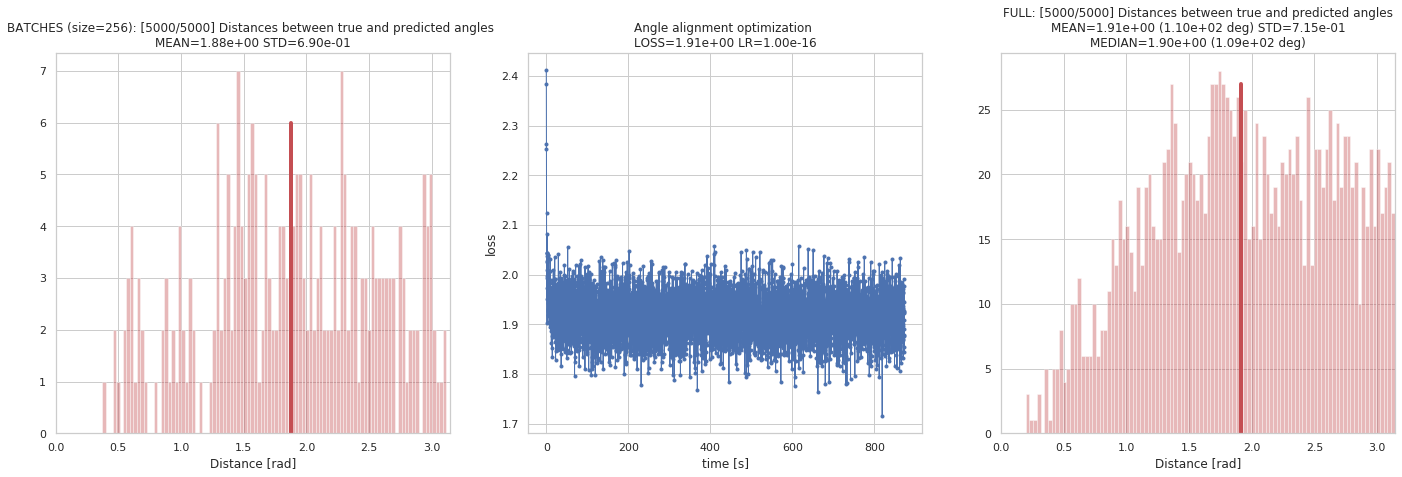

step 500/5000 (86s): loss = 1.93e+00
step 1000/5000 (173s): loss = 1.92e+00
step 1500/5000 (258s): loss = 1.92e+00
step 2000/5000 (346s): loss = 1.91e+00
step 2500/5000 (433s): loss = 1.92e+00
step 3000/5000 (520s): loss = 1.91e+00
step 3500/5000 (609s): loss = 1.92e+00
step 4000/5000 (698s): loss = 1.92e+00
step 4500/5000 (788s): loss = 1.92e+00
step 5000/5000 (874s): loss = 1.91e+00

---


In [33]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.1, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [34]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([ 5.99795062,  6.35418195,  0.4896981 ,  1.46645199, -0.37136765,
         6.10243942]),
 1.8764334622668768)

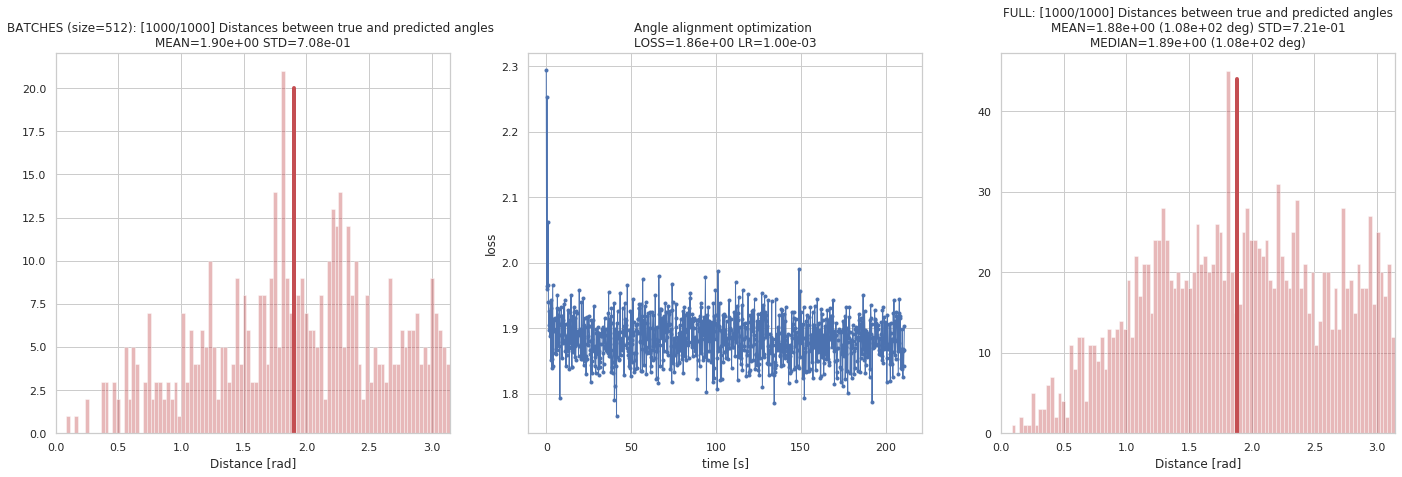

step 100/1000 (20s): loss = 1.91e+00
step 200/1000 (43s): loss = 1.88e+00
step 300/1000 (64s): loss = 1.89e+00
step 400/1000 (84s): loss = 1.89e+00
step 500/1000 (106s): loss = 1.89e+00
step 600/1000 (127s): loss = 1.89e+00
step 700/1000 (148s): loss = 1.88e+00
step 800/1000 (170s): loss = 1.88e+00
step 900/1000 (190s): loss = 1.88e+00
step 1000/1000 (212s): loss = 1.88e+00

---


In [60]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, -1.0],
                                                 steps=1000, 
                                                 batch_size=512, 
                                                 optimizer=Ftrl,
                                                 learning_rate=0.1,
                                                 learning_rate_power=-2.,
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [61]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, -1.0],
 array([-0.07603173, -0.40875797,  0.30534186,  4.89622495, -0.89862279,
         3.34718623]),
 1.9026925279817286)

##### Plots

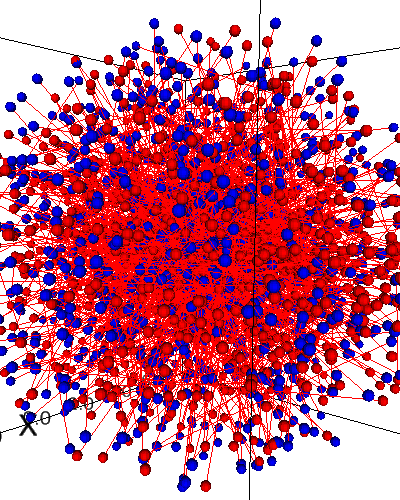

In [83]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=100);

In [84]:
ipv.screenshot()

Output()

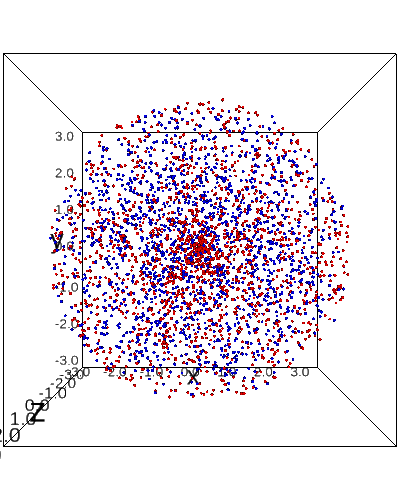

In [85]:
plot_iterations_rotvec(collect_data, angles_true[test_idx]);

In [86]:
ipv.screenshot()

Output()

In [62]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_siamese_updated_T.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')